<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Mention IA - CentraleSupélec - Visual Recognition  </center>
<hr style=" border:none; height:3px;">
</h1>

# Partie 1 : Video Magnification


Cette première partie du TP consistera à implémenter une version d'un algorithme d'amélioration de la qualité d'une vidéo qui se base sur des mouvements Eulériens. Il s'agit de l'approche décrite dans le papier de [Wu el al](http://people.csail.mit.edu/mrub/papers/vidmag.pdf) en 2012 lors de la conference SIGGRAPH. Prenez le temps de lire rapidement ce papier. Vous pouvez aussi consulter la page web du projet [ici](http://people.csail.mit.edu/mrub/evm/) et [ici](http://people.csail.mit.edu/mrub/vidmag/#publications).

Vous pouvez aussi regarder la vidéo qui explique le principe de l'approche.


In [1]:
from IPython.display import IFrame
IFrame('https://www.youtube.com/embed/ONZcjs1Pjmk', width=700, height=350)

La méthode proposée permet d'amplifier les couleurs et les mouvements d'une simple vidéo pour nous aider à visualiser les changements imperceptibles du monde qui nous entoure.



## 1. 1. Récupération des données

Un ensemble de vidéos est disponible dans le répertoire [data](./data). 

Votre premier travail consistera à écrire une fonction permettant de charger et de lire une vidéo et de la transformer en une liste de frames (array numpy).

Vous pourrez pour cela utiliser la fonction `cv2.VideoCapture` en vous inspirant de cette [documentation](https://docs.opencv.org/4.7.0/dd/d43/tutorial_py_video_display.html)



In [2]:
import cv2
import numpy as np


def load_video(vidFile):
    '''
    Reads the video
    :param vidFile: Video file
    :return: video sequence, frame rate, width & height of video frames
    '''
    print('Load video')
    
    frames = []

    cap = cv2.VideoCapture(vidFile)
    ret = True
    
    vidWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    vidHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fr = cap.get(cv2.CAP_PROP_FPS)
    
    while ret:
        ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
        if ret:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames.append(img)
    video_stack = np.stack(frames, axis=0) # dimensions (T, H, W, C)
        
    return video_stack, fr, vidWidth, vidHeight


Tester votre fonction sur une des vidéos fournies dans le répertoire [data](./data)

In [3]:
video_stack, fr, vidWidth, vidHeight = load_video("./data/baby.mp4")

Load video


Pour ceux qui auraient des difficultés avec cette fonction. Vous trouverez dans le répertoire [./data/Images](./data/Images) les images correspondants à la vidéo `baby.mp4` qui est composée de 300 frames.

Dans la suite, vous aurez aussi besoin d'une fonction qui permet de sauvegarder une vidéo. Cette fonction vous est donnée ci-dessous.

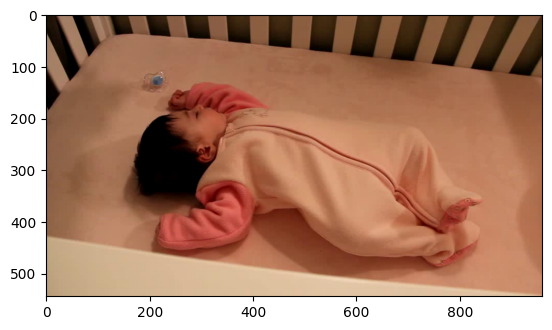

In [4]:
from matplotlib import pyplot as plt

plt.imshow(video_stack[0])
plt.show()

In [5]:
import platform


def save_video(video_tensor, fps, name):
    '''
    Creates a new video for the output
    :param video_tensor: filtered video sequence
    :param fps: frame rate of original video
    :param name: output video name
    '''
    print('Save video')
    if platform.system()=='Linux':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    else:
        fourcc = cv2.VideoWriter_fourcc(*'PIM1')
    [height, width] = video_tensor[0].shape[0:2]
    writer = cv2.VideoWriter(name+"Out.avi", fourcc, fps, (width, height), 1)
    for i in range(video_tensor.shape[0]):
        writer.write(cv2.convertScaleAbs(video_tensor[i]))
    writer.release()

## 1.2 Conversion des images couleur dans l'espace YIQ

La première étape de l'algorithme de magnification consiste à convertir les images RVB composant la vidéo d'entrée en YIQ. La composante Y représente la luminosité, I et Q représentent la chrominance (c'est-à-dire l'information sur les couleurs). Cet espace colorimétrique permet de manipuler les couleurs d'une image indépendamment de sa luminosité. La conversion de RVB en YIQ peut être effectuée à l'aide de la formule suivante

<center><img src='./Figs/rgbToYiq.png' width=400></center>

Compléter les fonctions suivantes permettant de convertir une image de l'espace colorimétrique RGB (ou BGR) à YIQ et inversement.

In [6]:
#convert RBG to YIQ
def rgb2yiq(src):
    rgb2yiq_mat = np.array([[0.299, 0.587 , 0.114],
                            [0.595716, -0.274453 , -0.321263],
                            [0.211456, -0.522591 , 0.311135]])
    
    new_image = np.zeros((src.shape[0], src.shape[1], 3), dtype= np.uint8)
    
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            new_image[i,j] = rgb2yiq_mat@src[i,j]
        
        
    return np.clip(new_image, 0,255)

On a aussi la conversion entre YIQ et RGB
<center><img src='./Figs/yiq2rgb.svg' width=400></center>


In [7]:
#convert YIQ to RBG
def yiq2rgb(src):
    yiq2rgb_mat = np.array([[1, 0.9563 , 0.6210],
                            [1, -0.2721 , -0.6474],
                            [1, -1.1070 , 1.7046]])
    
    new_image = np.zeros((src.shape[0], src.shape[1], 3), dtype= np.uint8)
    
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            new_image[i,j] = yiq2rgb_mat@src[i,j]
        
        
    return np.clip(new_image, 0,255)
    

Tester vos fonctions sur une image provenant de la video `baby.mp4` et afficher les images obtenues.

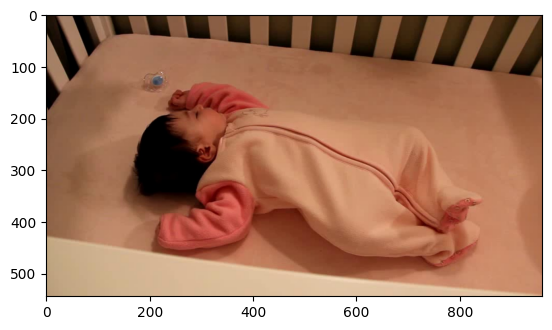

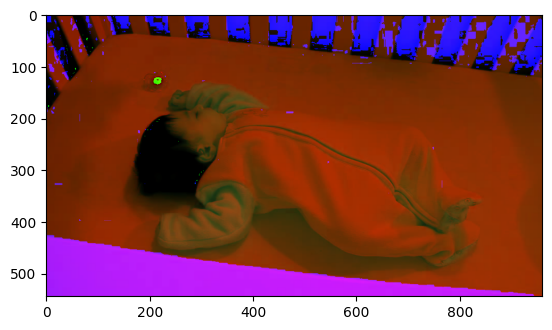

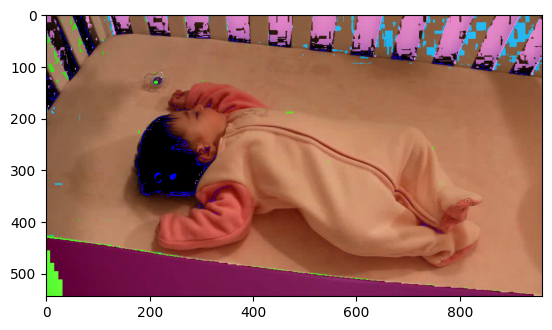

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

img = cv2.imread("./data/Images/baby_0.jpg",1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

img_yiq = rgb2yiq(img)
# img_yiq = np.clip(img_yiq, 0,255)

plt.imshow(img_yiq)
plt.show()

img_rgb = yiq2rgb(img_yiq)
# img_rgb = np.clip(img_rgb, 0,255)

plt.imshow(img_rgb)
plt.show()

## Magnification des couleurs
### 1.3 Construction d'une pyramide de gaussiennes.


Pour magnifier les couleurs, il faut construire une pyramide de gaussiennes de $l$ niveaux pour chaque image de la vidéo d'entrée. Pour cela,  il faudra prendre la version YIQ de chaque image originale et la sous-échantillonner d'un facteur 2 pour chaque nouveau niveau de la pyramide.

La première étape du sous-échantillonnage consiste donc à appliquer à l'image une convolution 2D avec le noyau gaussien 5x5 suivant :

$$G_{k} = \frac{1}{256}\begin{bmatrix}1 & 4 & 6 & 4 & 1\\4 & 16 & 24 & 16 & 4\\6 & 24 & 36 & 24 & 6\\4 & 16 & 24 & 16 & 4\\1 & 4 & 6 & 4 & 1\end{bmatrix}$$



Une fois la convolution effectuée, il ne faut conserver qu'un pixel sur deux dans les lignes et les colonnes de l'image, ce qui nous donne une image sous-échantillonnée dont la hauteur et la largeur sont divisées par 2 par rapport au niveau précédent de la pyramide. Nous effectuons ce processus $l -1 $ fois.

<center><img src='./Figs/gaussianpyramid.png' width=400></center>
Image source : [here](https://iipimage.sourceforge.io/documentation/images/)

Ecrivez la fonction qui prend en entrée une image (dans le bon espace colorimétrique) et qui renvoie une pyramide de gaussiennes de $l$ niveaux. Pour cela, vous pourrez utiliser les fonctions de la bibliothèque OpenCv et notamment la fonction [`pyrDown`](https://docs.opencv.org/4.7.0/d4/d1f/tutorial_pyramids.html) déjà vue en Lab. 

In [9]:
def build_gaussian_pyramid(img,levels):
    
    new_image = img
    
    for i in range(levels):
        new_image = cv2.pyrDown(new_image)
        
    return new_image

Tester votre fonction sur l'image [baby_0.jpg ](./data/Images/baby_0.jpg) avec une pyramide de 5 niveaux. Vous pourrez par exemple tester la fonction sur l'image originale en RGB puis ensuite sur l'image transformée dans l'espace colorimétrique YIQ.

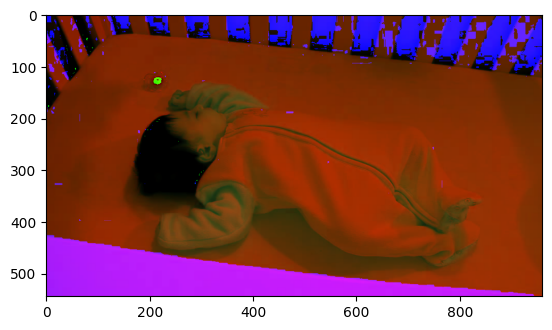

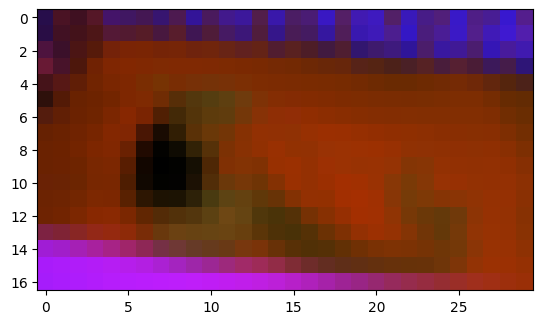

In [10]:
img = cv2.imread("./data/Images/baby_0.jpg",1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_yiq = rgb2yiq(img) 

plt.imshow(img_yiq)
plt.show()

img_pyr = build_gaussian_pyramid(img_yiq, levels=5)

plt.imshow(img_pyr)
plt.show()

Pour les étapes suivantes, vous ne conserverez que le dernier niveau de la pyramide. Plus précisemment, vous allez utiliser la version sur-échantillonnée du dernier niveau de la pyramide. Pour obtenir cette image suréchantillonnée, vous prendrez le dernier niveau de la pyramide, ajouterez un pixel fixé à 0 tous les deux pixels dans les lignes et les colonnes de l'image sous-échantillonnée et appliquerez $ 4 \times G_k$. Vous devez obtenir une image dont la hauteur et la largeur sont multipliées par 2 par rapport à l'image précédemment suréchantillonnée. Ce processus est effectué $l-1$ fois pour obtenir une image sur-échantillonnée de même dimension que l'image originale. Ici aussi, il est recommandé d'utiliser les fonctions de la bibliothèque OpenCv et notamment la fonction [`pyrUp`](https://docs.opencv.org/4.7.0/d4/d1f/tutorial_pyramids.html).

In [11]:
def generate_last_GaussianPyramid(image, level):
    
    img_pyr = build_gaussian_pyramid(image, level)
    
    for i in range(level):
        img_pyr = cv2.pyrUp(img_pyr)
        
    return img_pyr

Tester votre fonction sur l'image [baby_0.jpg ](./data/Images/baby_0.jpg) avec une pyramide de 5 niveaux. Vous pourrez par exemple tester la fonction sur l'image originale en RGB puis ensuite sur l'image transformée dans l'espace colorimétrique YIQ.

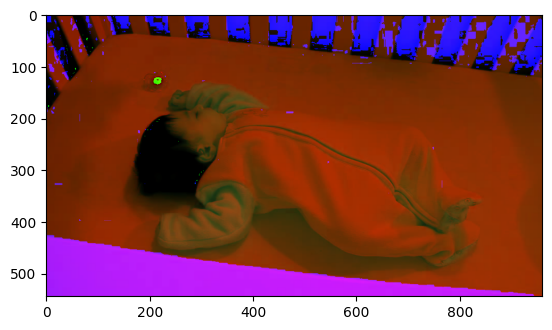

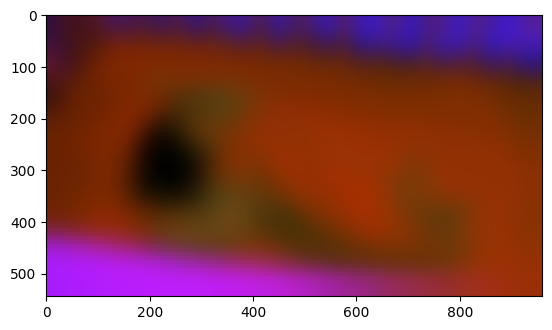

In [12]:
img = cv2.imread("./data/Images/baby_0.jpg",1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_yiq = rgb2yiq(img_rgb)

plt.imshow(img_yiq)
plt.show()

img_gaussian = generate_last_GaussianPyramid(img_yiq, level=5)

plt.imshow(img_gaussian)
plt.show()

## 1.4 Filtrage Temporel


Cette étape, la plus importante, consiste à filtrer la pyramide de gaussiennes afin de ne conserver que les pixels situés dans la **bande de fréquences** qui nous intéresse $[w_l, w_h]$. Pour cela, nous devons passer du domaine spatial (domaine de l'image) au domaine des fréquences à l'aide d'une transformée de Fourier.

Pour cela, vous allez utiliser le package [`fft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) de la bibliothèque `numpy`.

Si vous n'avez jamais entendu parler de la transformée de Fourier, prenez le temps de lire rapidement ce petit [tutorial](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm).


Le code ci-dessous vous montre un exemple d'application de cette bibliothèque sur l'image [baby_0.jpg ](./data/Images/baby_0.jpg)

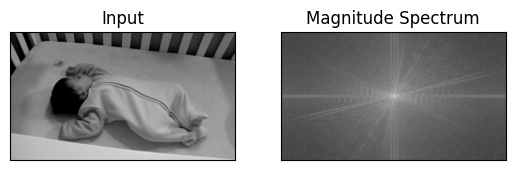

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import cv2


img = cv2.imread("./data/Images/baby_0.jpg",0)
# rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axis =0

fft = np.fft.fft2(img)

# Shift the zero frequency component (i.e., DC component located at the top-left corner) to the center where it will be more easy to analyze

fftShift = np.fft.fftshift(fft)

# compute the magnitude spectrum of the transform

magnitude = 20 * np.log(np.abs(fftShift))

# Visualize the obtained image
# display the original input image
(fig, ax) = plt.subplots(1, 2, )
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Input")
ax[0].set_xticks([])
ax[0].set_yticks([])
# display the magnitude image
ax[1].imshow(magnitude, cmap="gray")
ax[1].set_title("Magnitude Spectrum")
ax[1].set_xticks([])
ax[1].set_yticks([])
# show our plots
plt.show()




Pour notre problème, il s'agira d'appliquer la transformée de Fourier et de ne conserver que les pixels situés dans la **bande de fréquences** qui nous intéresse $[w_l, w_h]$ ce que l'on pourra faire de la manière suivante.

In [14]:
low=0.8333
high = 1

fft = np.fft.fft(img)
fps = 25

frequencies = np.fft.fftfreq(img.shape[0], d=1.0/fps)

bound_low = (np.abs(frequencies - low)).argmin()
bound_high = (np.abs(frequencies - high)).argmin()

fft[:bound_low] = 0
fft[bound_high:-bound_high] = 0
fft[-bound_low:] = 0



Il faut ensuite appliquer la transformée de Fourier inverse pour obtenir une image filtrée. Le résultat d'une transformée de Fourier inverse est une matrice de nombres complexes, il faudra donc prendre la la partie réelle de chaque nombre de la matrice complexe.

In [15]:
resultifft = np.fft.ifft(fft, axis=0).real
print(resultifft.shape)

(544, 960)


A partir des exemples précédents, écrire une fonction `idealTemporalBandpassFilter` qui prend en argument une image, un paramètre `fps`(frame per second), la banque de fréquence voulue (paramètres `low` et `high`) et un argument `axis` qui est fixé par défaut à 0 et qui renvoie la transformée inverse filtrée.

In [16]:
def idealTemporalBandpassFilter(images,
                                fps,
                                freq_range,
                                axis=0):

    fft = np.fft.fft(images)
    
    frequencies = np.fft.fftfreq(images.shape[0], d=1.0/fps)
    
    low = freq_range[0]
    high = freq_range[1]
    
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    
    resultifft = np.fft.ifft(fft, axis=axis).real
    
    return resultifft

## 1.5 Magnification de l' image et reconstruction.

Pour amplifier les couleurs obtenues avec la pyramide filtrée $F_p$, il est nécessaire d'introduire une valeur $\alpha$ qui va agir comme une **facteur d'amplification**. Pour éviter la création d'artefacts dans l'image de sortie, nous introduisons une autre valeur $A$ qui agira comme un facteur d'atténuation pour les composantes de chrominance de l'image. Nous obtenons notre pyramide filtrée magnifiée $M_{F_P}$ avec une atténuation de la chrominance avec la formule suivante :

$$M_{F_{p}} = \begin{cases}\alpha F_{p}\ \text{if Y component}\\ \alpha A F_{p}\ \text{if I or Q component}\end{cases}$$

On peut finalement reconstruire l'image en ajoutant $M_{F_P}$ à la version YIQ de l'image originale et en convertissant l'image résultante en RGB en pensant bien à limiter les valeurs dans l'intervalle $[0,255]$ pour chaque composante. Ce processus devra être répété pour chaque frame de la vidéo.



Ecrire une fonction `filterGaussianPyramids` qui, pour une frame donnée, prend en entrée la pyramide de gaussiennes, la filtre, applique les opérations d'amplification et d'attenuation. Cette fonction prendra aussi en arguments le `fps`, la bande de fréquences et les paramètres `alpha` et `attenuation`. 


In [17]:
def filterGaussianPyramids(pyramids,
                           fps,
                           freq_range,
                           alpha,
                           attenuation):

    ifft = idealTemporalBandpassFilter(pyramids,
                                        fps,
                                        freq_range,
                                        axis=0)
    
    new_image = np.zeros((pyramids.shape[0], pyramids.shape[1], 3), dtype= np.uint8)
    
    for i in range(ifft.shape[0]):
        for j in range(ifft.shape[1]):
            new_image[i,j,0] = alpha * ifft[i,j,0]
            new_image[i,j,1] = attenuation * ifft[i,j,1]
            new_image[i,j,2] = attenuation * ifft[i,j,2]
        
    return new_image

Ecrire une fonction qui reconstruit l'image magnifiée en ajoutant $M_{F_P}$ à la version YIQ de l'image originale et en convertissant l'image résultante en RGB en pensant bien à limiter les valeurs dans l'intervalle $[0,255]$ pour chaque composante. Elle prendra en argument l'image originale et la pyramide de gaussienne filtrée.

In [18]:
def reconstructGaussianImage(image, pyramid):    
    # #Conversion YIQ
    # img_yiq = rgb2yiq(image)
    img_yiq = image
    
    #Ajout de MF a la version YIQ
    img_add = np.clip(pyramid + img_yiq, 0, 255)
    
    #Conversion RGB
    rgb = yiq2rgb(img_add)
    
    return rgb
    
    

Tester vos fonctions sur l'image `baby_0.jpg` avec une pyramide de 4 niveaux, 

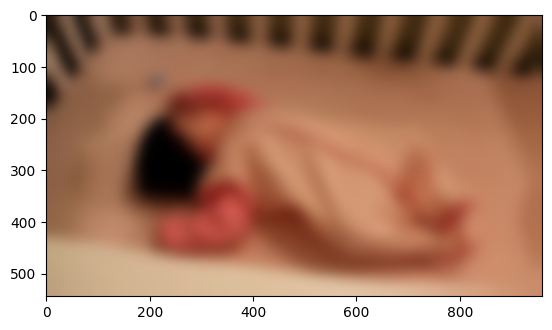

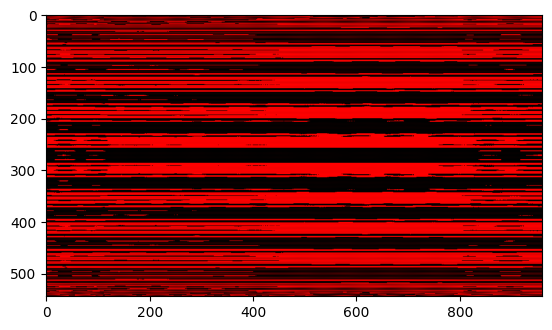

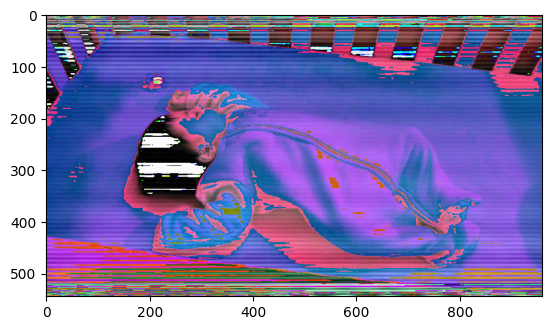

In [19]:
img = cv2.imread("./data/Images/baby_0.jpg",1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_yiq = rgb2yiq(img_rgb)
img_yiq= img_rgb

#Génération de la pyramide
pyramide = generate_last_GaussianPyramid(img_yiq, level=4)

plt.imshow(pyramide)
plt.show()

#Pyramide filtrée
filtered_pyr = filterGaussianPyramids(pyramide,
                                       fps = 25,
                                       freq_range = [0.4, 3],
                                       alpha = 15,
                                       attenuation = 0.1)

plt.imshow(filtered_pyr)
plt.show()

#Reconstruction image magnifiée
mag_img = reconstructGaussianImage(img_yiq, filtered_pyr)

plt.imshow(mag_img)
plt.show()

In [20]:
def magnify_img(img, level):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_yiq = rgb2yiq(img_rgb)

    #Génération de la pyramide
    pyramide = generate_last_GaussianPyramid(img_yiq, level)

    #Pyramide filtrée
    filtered_pyr = filterGaussianPyramids(pyramide,
                                           fps = 25,
                                           freq_range = [0.4, 3],
                                           alpha = 15,
                                           attenuation = 0.1)
    

    #Reconstruction image magnifiée
    mag_img = reconstructGaussianImage(img_yiq, filtered_pyr)
    
    return mag_img

### 1.6 Application à la vidéo


Ecrire le code permettant d'appliquer cela à une vidéo et qui renverra donc la vidéo magnifiée.

In [21]:
def gaussian_video(video_tensor, levels):
    '''
    For a given video sequence the function creates a video with
    the highest (specified by levels) Gaussian pyramid level
    :param video_tensor: Video sequence
    :param levels: Specifies the Gaussian pyramid levels
    :return: a video sequence where each frame is the downsampled of the original frame
    '''
    gaussian_video = video_tensor.copy()
    
    print("Gaussian video generation")
    
    for i in range(video_tensor.shape[0]):
        gaussian_video[i] = rgb2yiq(gaussian_video[i])
        gaussian_video[i] = generate_last_GaussianPyramid(gaussian_video[i], levels)

    return gaussian_video
    

In [22]:
low = 0.4
high = 3
alpha = 15
chromAttenuation = 0.1

Load video
Gaussian video generation


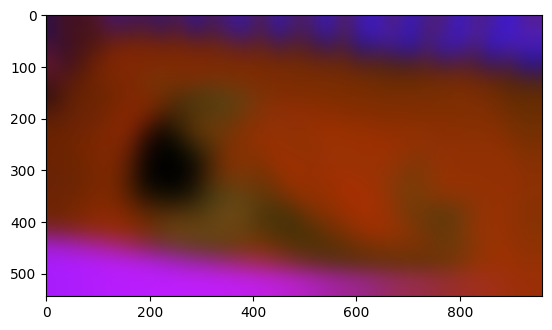

In [23]:
t, fps, width, height = load_video("./data/baby.mp4")

t_gaussian = gaussian_video(t, 5)

plt.imshow(t_gaussian[0])
plt.show()

In [24]:
with open('t_gaussian.npy', 'wb') as f:
    np.save(f, t_gaussian)

In [25]:
with open('t_gaussian.npy', 'rb') as f:
    t_gaussian = np.load(f)

In [49]:
t_filtered = t_gaussian.copy()

for i in range(t_gaussian.shape[0]):
    t_filtered[i] = filterGaussianPyramids(t_filtered[i],
                                               fps = fps,
                                               freq_range = [low, high],
                                               alpha = alpha,
                                               attenuation = chromAttenuation)

In [ ]:
with open('t_filtered.npy', 'wb') as f:
    np.save(f, t_filtered)

In [26]:
with open('t_filtered.npy', 'rb') as f:
    t_filtered = np.load(f)

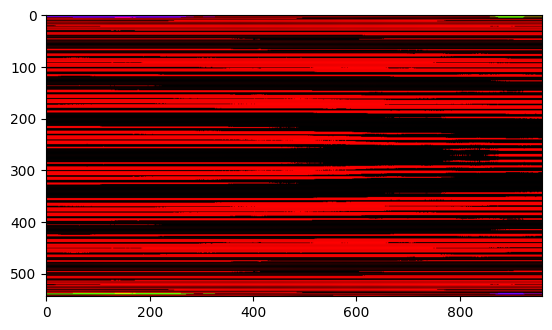

In [27]:
plt.imshow(t_filtered[0])
plt.show()

In [28]:
t_magnified = t_filtered.copy()

for i in range(t_filtered.shape[0]):
    t_magnified[i] = reconstructGaussianImage(t_gaussian[i],  t_magnified[i])

In [29]:
with open('t_magnified.npy', 'wb') as f:
    np.save(f, t_magnified)

In [28]:
with open('t_magnified.npy', 'rb') as f:
    t_magnified = np.load(f)


## Magnification des mouvements
### 1.6 Pyramide de laplaciens

Pour la magnification des mouvements, il faut se concentrer sur les bords des objets dans la vidéo. Pour cela, vous allez utiliser la différence entre deux niveaux adjacents de la pyramide gaussienne, c'est-à-dire une pyramide de Laplacien comme illustré sur la figure ci-dessous

<center><img src='./Figs/laplacian_pyramid.png' width=500></center>



Ecrire la fonction `create_laplacian_pyramid` qui prend en agurment une image et le niveau voulu $l$ de la pyramide et qui renvoie une pyramide de laplacien de $l$ niveaux.

In [29]:
def create_laplacian_pyramid(image, levels):
    '''
    Builds a Laplace pyramid for an image, i.e. video frame
    :param image: Image,  i.e. single video frame
    :param levels: Specifies the Laplace pyramid levels
    :return: Returns a pyramid of nr. levels images
    '''
    gaussian = []  

    gaussian_layer= image.copy() 

    for i in range(levels):
        gaussian_layer = cv2.pyrDown(gaussian_layer)
        gaussian.append(gaussian_layer)

    laplacian = [gaussian[-1]] 

    for i in range(levels, 0, -1):
        size = (gaussian[i - 1].shape[1], gaussian[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian[i], dstsize=size)
        laplacian_layer = cv2.subtract(gaussian[i-1], gaussian_expanded)
        laplacian.append(laplacian_layer)

    return laplacian


Ecrire une fonction qui permet de créer la pyramide des laplaciens pour l'ensemble d'une vidéo.

In [30]:
def laplacian_video_pyramid(video_stack, levels):
    '''
    Creates a Laplacian pyramid for the whole video sequence
    :param video_stack: Video sequence
    :param levels: Specifies the Laplace pyramid levels
    :return: A two-dimensional array where the first index is used for the pyramid levels
    and the second for each video frame
    '''
    print('Build laplace pyramid')
    
    num_frames = video_stack.shape[0]

    # Créer une liste vide pour chaque niveau de la pyramide
    laplacian_pyramid = [[] for i in range(levels)]

    for i in range(num_frames):
        frame = video_stack[i]
        pyramid = create_laplacian_pyramid(frame, levels)
        for j in range(levels):
            laplacian_pyramid[j].append(pyramid[j])

    
    laplacian_pyramid = [np.stack(level) for level in laplacian_pyramid]
    laplacian_pyramid = np.stack(laplacian_pyramid, axis=0)

    return laplacian_pyramid


### 1.7 Filtre de Butterworth

Pour l'étape de filtrage de la magnification des mouvements, il faut un filtre qui tolère les fréquences en dehors de la plage donnée, car les changements de mouvements ne sont pas aussi uniformes que les changements de couleurs. Nous utiliserons donc un filtre de Butterworth dont un descriptif est donné [ici](https://fr.wikipedia.org/wiki/Filtre_de_Butterworth).

Dans le papier original, les auteurs proposent d'utiliser un filtre passe-bande de Butterworth du premier ordre, comme dans l'exemple suivant.

<center><img src='./Figs/butterworth.png' width=500></center>


Filtre de Butterworth avec $w_l = 2 $ et $w_h = 4$.





Pour filtrer les images, il faut d'abord calculer les coefficients
 $b_i$ et $a_i$ du filtre de Butterworth étant donné la bande de fréquence $[w_l, w_h]$ et le frame rate $fps$ de la video comme fréquence temporelle.


Pour ce filtrage, vous pourrez utiliser la fonction [`butter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) de `scipy`.
 
 
Vous trouverez ci-dessous la fonction  `butter_bandpass` qui calcule le filtre de Butterworth d'ordre 1 étant donné la bande de fréquence et le frame rate.
 
 
 

In [31]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fps, order=1):
    '''
    Calculates the Butterworth bandpass filter
    :param lowcut: low frequency cutoff
    :param highcut: high frequency cutoff
    :param fs: video frame rate
    :param order: filter order - per default = 1
    :return: Numerator (b) and denominator (a) polynomials of the IIR filter.
    '''

    low = lowcut / fps
    high = highcut / fps
    b, a = butter(order, [low, high], btype='band')
    return b, a

### 1.8 Application du filtre de Butterworth au Laplacien.

Il s'agit maintenant d'appliquer le filtre en suivant l'équation ci-dessous.

$$y[n] = \frac{1}{a_0}(b_{0}x[n] + b_{1}x[n - 1] - a_{1}y[n - 1])$$
 
Avec  $y[n]$ la nième image de la pyramide laplacienne filtrée et $x[n]$ la nième pyramide de Laplace (correspondant à la nième frame)

$y[0]$  et $x[0]$ sont les pyramides de Laplace pour la première frame de la vidéo.


Ecrire la fonction `apply_filter_butter` qui prend en entrée une séquence d'images et qui applique l'équation précédente, donc le filtre de Butterworth à tous les niveaux d'une pyramide de Laplace d'une séquence d'images.


In [33]:
def apply_filter_butter_to_laplacian(laplace_video_list, levels, low, high, fps):
    '''
    Applies the Butterworth filter on video sequence
    :param laplace_video_list: Laplace video pyramid
    :param levels: Pyramid levels
    :param low: Temporal low frequency cutoff
    :param high: Temporal high frequency cutoff
    :return:
    '''

    print('Apply Butterworth filter')

    # Filter coefficients
    b, a = butter_bandpass(low, high, fps, order=1)

    filtered_laplace_pyramid = []

    for l in range(levels):
        laplace_level = laplace_video_list[l]

        filtered_level = np.zeros((laplace_level.shape))

        for t in range(laplace_level.shape[0]):
            
            
            
            if t == 0:
                #x0 = y0 si j'ai bien compris
                filtered_frame = laplace_level[t]
            else:
                curr_frame = laplace_level[t]
                prev_frame = laplace_level[t-1]
                prev_filtered_frame = filtered_level[t-1]

                #Equation de Butterworth
                filtered_frame = (1/a[0]) * (b[0] * curr_frame + b[1] * prev_frame - a[1] * filtered_level[t-1]) 
            
            # Save filtered frame
            filtered_level[t] = filtered_frame

        # Save filtered level
        filtered_laplace_pyramid.append(filtered_level)

    return filtered_laplace_pyramid                                    

### 1.8 Magnification & Reconstruction

Dans le cas de la magnification de mouvements, tous les niveaux de la pyramide de Laplacien sont utilisés et donc l'étape de magnification et de reconstruction des mouvements est un peu plus compliquée. Tout d'abord, nous devons adapter dynamiquement le facteur d'amplification pour chaque niveau de la pyramide. Pour ce faire, nous introduisons la longueur d'onde spatiale $\lambda$ qui représente un niveau donnée de la pyramide de Laplace filtrée 

$$\lambda = \sqrt{h^{2} + w^{2}}$$

Avec $h$ et $w$ qui sont respectivement la hauteur et la largeur du niveau considéré. 

$\lambda$ et le facteur d'amplification $\alpha$ sont liés par l'équation suivante : 

$$(1 + \alpha)\delta (t) < \frac{\lambda}{8}$$

Avec $\delta (t)$ le facteur de déplacement (se reporter à l'article pour plus de détails).

Nous pouvons maintenant introduire la longueur d'onde spatiale de coupure $\lambda_{c}$

$$(1 + \alpha)\delta(t) = \frac{\lambda_{c}}{8} \implies \delta(t) = \frac{\frac{\lambda_{c}}{8}}{1 + \alpha}$$

Le nouveau facteur d'amplication $\alpha_{\textrm{new}}$ pour un niveau donnée de la pyramide $F_p$ peut alors être obtenu par 

$$\alpha_{\textrm{new}} = \frac{\frac{\lambda}{8}}{\delta(t)} - 1$$

Le facteur d'amplication est alors pour un niveau $l$ de $F_p$

$$\alpha_{l} = min(\alpha, \alpha_{\textrm{new}})$$

De la même manière que pour la magnification de la pyramide de Gaussiennes, nous obtenons notre niveau de pyramide filtrée magnifiée avec 

$$M_{F_{p}}[l] = \begin{cases}\alpha_{l} F_{p}[l]\ \text{if Y component}\\ \alpha_{l} A F_{p}[l]\ \text{if I or Q component}\end{cases}$$


Nous répétons le processus précédent pour tous les niveaux (sauf le premier et le dernier) de $F_p$.

Enfin, nous reconstruisons notre image en suréchantillonnant tous les niveaux de $M_{F_{p}}$ aux dimensions de l'image originale, en l'ajoutant à la version YIQ de l'image originale, en convertissant l'image résultante en RVB et en limitant les valeurs de l'image RVB résultante à $[0,255]$. Ce processus est répété pour chaque frame de la vidéo.

Compléter la fonction ci-dessous qui permet de mettre en oeuvre ce processus.

In [ ]:
def apply_butter(laplace_video_list, levels, alpha, cutoff, low, high, fps, width, height, linearAttenuation):
    '''
    Applies the Butterworth filter on video sequence, magnifies the filtered video sequence
    and cuts off spatial frequencies
    :param laplace_video_list: Laplace video pyramid
    :param levels: Pyramid levels
    :param alpha: Magnification factor
    :param cutoff: Spatial frequencies cutoff factor
    :param low: Temporal low frequency cutoff
    :param high: Temporal high frequency cutoff
    :param fps: Video frame rate
    :param width: Video frame width
    :param height: Video frame height
    :param linearAttenuation: Boolean if linear attenuation should be applied
    :return:
    '''

    print('Apply Butterworth filter and magnification' )
    filtered_video_list = []
    b, a = butter_bandpass(low, high, fps, order=1)

    # spatial wavelength lambda
    lambda1 = # To complete

    delta = # To complete (equation abec la fréquence spatiale de coupure  : cutoff)

    for i in range(levels):  # pyramid levels

        current_alpha = # To complete  # given in paper


        # apply the butterworth filter onto temporal image sequence
        # To complete

        # spatial frequencies attenuation
        # To complete

Ecrire une fonction qui permet de reconstruire une séquence vidéo à partir de la pyramide de Laplaciens filtrée

In [ ]:
def reconstruct(filtered_video, levels):
    '''
    Reconstructs a video sequence from the filtered Laplace video pyramid
    :param filtered_video: 2 dimensional video sequence - 1st. index pyramid levels, 2nd. - video frames
    :param levels: pyramid levels
    :return: video sequence
    '''
    print('Reconstruct video')

    # To complete

Ecrire une fontion qui permet de mettre en place l'amplification de mouvement sur une vidéo complète et sauvegarder la vidéo amplifiée.

In [ ]:
def motionmagnification(vidFile, alpha, cutoff, low, high, chromAttenuation, name):
    '''
    Performs motion magnification on the video by applying Butterworth bandpass filter and saves the output video
    :param vidFile: Video file
    :param alpha: Magnification factor
    :param cutoff: Spatial frequencies cutoff factor
    :param low: Temporal low frequency cutoff
    :param high: Temporal high frequency cutoff
    :param chromAttenuation: chrominance attenuation 
    :param name: Output video name
    '''
    # To complete

Tester sur les vidéos du répertoire [data](./data). Vous sauvegarderez les vidéos résultats. Ci-dessous un ensemble de valeurs pour les paramètres pour la vidéo baby mais vous pouvez bien evidemment tester différents paramètres.

In [ ]:
# Quelques paramètres à utiliser

# pour la video baby

low = 0.4
high = 3
alpha = 15
chromAttenuation = 0.1
cutoff =  16



# Partie 2 : Générateur d'images Low Poly


L'objectif de cette partie est de mettre en place plusieurs approches simples permettant, à partir d'une image source de générer une image artistique dite Low Poly.
Ces images ont comme particularité  :

 + Les objets illustrés sont très abstraits et schématiques. Ils ne respectent pas vraiment la réalité.
 + Les objets sont illustrés à l'aide de formes basiques, tels que des triangles et des polygones simples.
 + Une palette de couleur simple est utilisé et il n'y pas beaucoup de contenu fréquentielle ou des textures complexes.

Il s'agit ici. de développer des fonctions permettant de transformer une image en une version Low-Poly comme sur l'exemple ci-dessous


<center><img src='./Figs/oscar.jpg' width=200></center>


<center><img src='./Figs/oscarlowpoly.png' width=200></center>

## 2.1 : Approche à l'aide de points d'intérêts

Une première approche consiste à faire en place la chaîne de traitements suivantes :

 1. Déterminer des points  (d'interêts ) dans l'image
 2. Générer une triangulation de type Delaunay
 3. Remplir les triangles à l'aide des couleurs de l'image originale.

Il s'agit donc de mettre en place cette première statégie.


Pour l'extraction des points dans l'image, vous comparerez trois stratégies :
 + La sélection de points de manière aléatoire
 + La sélection de points sur les contours
 + la sélection de points d'intérêts (Harris, sift et cie)

### 2.1.1 Extraction de points d'intérêts de manière aléatoire

Ecrire une fonction qui prend en entrée une image et qui selectionne de manière aléatoire un ensemble de $n$ points dans une image et qui renvoie cet ensemble de points.


In [36]:
import random
import cv2

def select_at_random (img, n):
    pixel_list = [pixel for row in img for pixel in row]
    
    return random.sample(pixel_list, n)

### 2.1.2 Extraction de points d'intérêts sur les contours.

Ecrire une fonction qui prend en entrée une image et qui selectionne de manière aléatoire un ensemble de $n$ points sur les contours d'une image donnée. Vous pourrez par exemple prendre pour cela le détecteur de contours de Canny déjà implémenté dans OpenCV : voir [ici](https://docs.opencv.org/4.7.0/da/d22/tutorial_py_canny.html).


In [37]:
def select_at_edge (img, n):
    edges = cv2.Canny(img,100,200)
    
    pixels_on_edges = [pixel for row in edges for pixel in row if pixel==[255,255,255]]
    
    return random.sample(pixels_on_edges, n)

### 2.1.3 Extraction de points d'intérêts de manière aléatoire

Ecrire une fonction qui prend en entrée une image et qui calcule à partir des fonctions pré-définies dans la bibliothèque OpenCV les points d'intérêts de cette images. Vous pouvez utiliser ici plusieurs approches de votre choix pour l'extraction de ces points d'intérêts comme par exemple les détecteurs sift ou d'autres. Voir [ici](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)


Ajouter à la liste des points les 4 coins de l'image

In [38]:
# points = [[0, 0], [0, h-1], [w-1, 0], [w-1, h-1]]

In [39]:
def select_interest_points (img, n):
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    
    keypoints = random.sample(kp, n)
    
    h, w = gray.shape
    points = [[0, 0], [0, h-1], [w-1, 0], [w-1, h-1]]
    
    for pt in points:
        corner = cv2.KeyPoint(pt[0], pt[1], 10, 0, 0, 0, 0)
        keypoints.append(corner)
        
    return keypoints

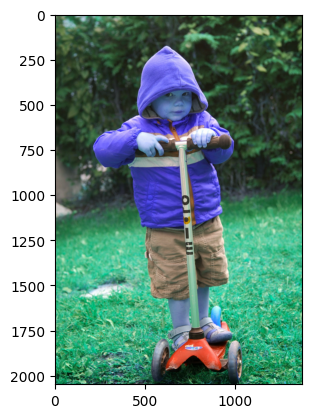

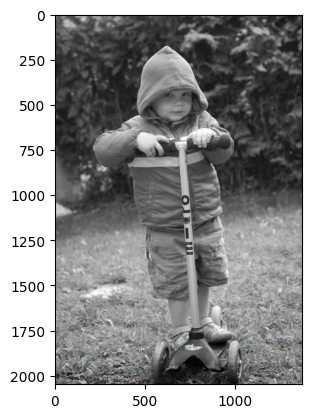

In [41]:
img = cv2.imread("Figs/oscar.jpg")
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kp = select_interest_points (img, 500)

keypoints = cv2.drawKeypoints(gray,kp,img)

# Afficher l'image avec les points d'intérêt
plt.imshow(keypoints)
plt.show()

### 2.1.4 Génération d'une triangulation de Delaunay à partir des points extraits.

Il s'agit ici de construire une [triangulation de Delaunay](https://fr.wikipedia.org/wiki/Triangulation_de_Delaunay) à partir des points extraits dans les étapes précédentes.

Pour cela, vous pourrez utiliser la bibiothèque `scipy` et le package [`spatial.Delaunay`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html).

Le code ci-dessous vous montre un exemple simple d'utilisation de ce package. On voit notamment que les indices des points qui forment les simplexes dans la triangulation sont données dans `_.simplices`.  


In [42]:
import numpy as np
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(points)
print(tri.simplices)

[[2 3 0]
 [3 1 0]]


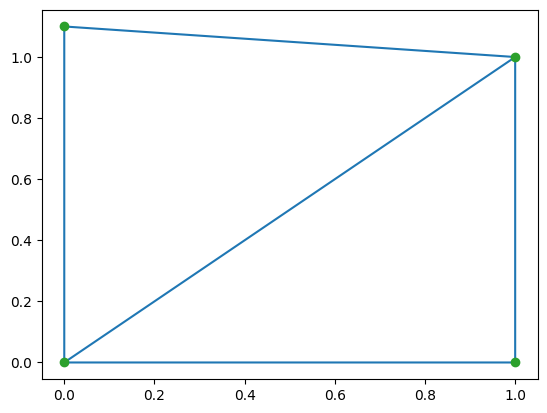

In [43]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

Ecrire une fonction qui à partir d'un ensemble de points extraits d'une image contruit la triangulation de Delaunay de cet ensemble de points 

In [44]:
def get_delaunay_random(image, n):
    points = select_at_random(image, n)
    return Delaunay(points)

In [45]:
def get_delaunay_edge(image, n):
    points = select_at_edges(image, n)
    return Delaunay(points)

In [50]:
def get_delaunay_sift(image, n):
    keypoints = select_interest_points(image, n)
    points = [list(map(float, kp.pt)) for kp in keypoints]
    return Delaunay(points)

### 2.1.5  Remplir les triangles à l'aide des couleurs de l'image originale

Ici il s'agit d'assigner chaque pixel à un triangle de la triangulation de Delaunay et de faire la moyenne des couleurs dans ce triangle pour obtenir l'image Low Poly



In [51]:
def get_colour_of_tri(tri, image):
    # assign each pixel to a triangle, and then take all the pixels in a triangle and average the colour and return the average color
    
    R = []
    G = []
    B = []
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #On teste si le pixel appartient au triangle
            beglongs_to = cv2.pointPolygonTest(tri, (j,i), True)
            
            if beglongs_to>1:
                R.append(image[i,j,0])
                G.append(image[i,j,1])
                B.append(image[i,j,2])
    
    tri_R = sum(R)/len(R) if len(R)>0 else 0
    tri_G = sum(G)/len(G) if len(G)>0 else 0
    tri_B = sum(B)/len(B) if len(B)>0 else 0
    
    return tri_R, tri_G, tri_B    
                    

Ecrire la fonction permettant de générer l'image Low Poly. Il s'agit donc de tracer les triangles et de donner la couleur moyenne des pixels à l'intérieur de chaque triangle. Les fonctions [`cv2.line`](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html) et [`find_simplex`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.find_simplex.html) pourraient vous être utiles.

In [52]:
def generate_low_poly_img (img):
    tri = get_delaunay_sift(img, 10)
    
    triangle_coord = tri.points[:,:2]


    # for i in triangle_list:
    for i in range(tri.nsimplex):
        
        idx = tri.simplices[i]
        triangle = np.array([triangle_coord[idx[0]], triangle_coord[idx[1]], triangle_coord[idx[2]]], np.int32)
        
        R,G,B = get_colour_of_tri(triangle, img)
        
        triangle = triangle.reshape((-1,1,2))
        
        cv2.fillPoly(img, [triangle], color=(R, G, B))
    
    plt.imshow(img)
    plt.show()
    

Tester vos différentes approches sur les images du répertoire [lowpoly](./lowpoly) et afficher les images originales et les images obtenues.

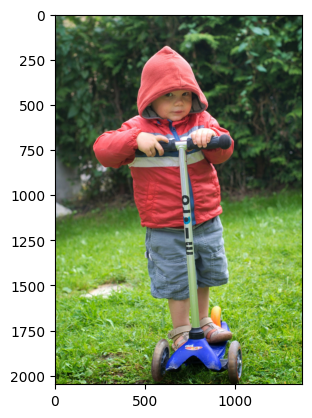

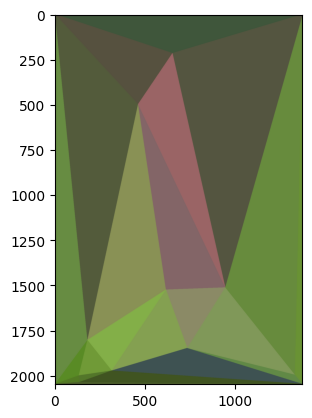

In [53]:
img = cv2.imread("Figs/oscar.jpg")
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

generate_low_poly_img (rgb)